In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

# cluster functions
empty = [0]
point = [1,2]
pair_1 = [3,4]
pair_2 = [5,6,7]
pair_3 = [8,9,10,11]
pair_4 = [12,13,14,15]
triplet_1 = [16,17]
#triplet_2 = [18,19,20,21]

def select_cluster(df_corr, clusters):
    clus = []
    for i in clusters:
        clus = clus + i
    clus = np.array(clus)
    return df_corr.iloc[:,clus]

def regularize_dos(df_dos, grid_fine, smooth_width=0, log=False):
    df_dos_fine = pd.DataFrame(index=df_dos.index, columns=['dos_hse'])
    for i in df_dos.index:
        dos = df_dos.loc[i, "dos_hse"]
        grid_coarse = df_dos.loc[i, "energy_hse"]
        if smooth_width > 0:
            box = np.ones(smooth_width)/smooth_width
            dos = np.convolve(dos, box, mode='same')
        f = interpolate.interp1d(grid_coarse,dos)
        df_dos_fine.loc[i,"dos_hse"] = f(grid_fine)
    if log:
        _dos_log = df_dos_fine.copy()
        for i in df_dos_fine.index:
            _dos_log.loc[i,'dos_hse'] = np.log(df_dos_fine.loc[i,'dos_hse']+0.1)
        df_dos_fine = _dos_log
    return df_dos_fine

def weight(df_dos, gap_max, w_exp):
    w = np.exp((gap_max-df_dos.gap.values.astype(float))/w_exp)
    return w

def calc_model(corr,x, w):
    lasso = linear_model.Lasso(fit_intercept=False)
    ridge = linear_model.Ridge(fit_intercept=False)
    alphas = np.logspace(-5, 0, 5)
    params = [{'alpha': alphas}]
    #reg.fit(corr.values, x, w)
    #model = linear_model.RidgeCV(alphas=[0.001, 0.01, 0.1, 1], fit_intercept=False, cv=3)
    model = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5, refit=True, return_train_score= True)
    model.fit(corr.values, x)
    return model

def match(df_dos, df_corr):
    overlap = list(set(df_dos['configname']).intersection(set(df_corr['configname'])))
    if len(overlap) < len(df_dos['configname']):
        raise ValueError('DOS and correlation data inconsistent.')
    df = pd.DataFrame()
    for i in df_dos['configname']:
        df = df.append(df_corr[df_corr['configname'] == i])
    return df

def main(mat, clusters, gap_th=0.2, w_exp=0.1, align=False, verbose=False):
    global grid_fine, df_dos_fine, ref_ind
    smooth_width = 5 # the box width used to smooth the density of states
    is_log = False
    #grid_fine = np.arange(2,8,0.02) # grid for the selected energy range
    # read corr matrix and electronic densities
    df_corr = pd.read_csv('corr_{0}.csv'.format(mat), delim_whitespace=True)
    df_dos = pd.read_hdf('pdos_{0}.h5'.format(mat))
    # semiconductors only
    # drop metallic structures
    #
    df_dos = df_dos[df_dos['configname'].str.contains('SCEL1|SCEL2|SCEL3')]
    #
    semi = df_dos[(df_dos.gap > gap_th)].index
    df_dos = df_dos.loc[semi]
    df_corr = match(df_dos, df_corr)
    #
    assert (df_dos.index == df_corr.index).all()
    #ref_ind = df_dos.gap.idxmax()
    if mat == 'czts':
        ref_ind = 1
    else:
        ref_ind = 0
    vbm = df_dos.loc[ref_ind, 'vbm']
    # interpolate the dos on a specific regular mesh
    #df_dos_fine = regularize_dos(df_dos, grid_fine, smooth_width=smooth_width, log=is_log)
    #
    # define training set
    #train = df_corr.sample(frac=1, random_state=None)
    train = df_corr
    if ref_ind not in train.index:
        train = train.append(df_corr.loc[ref_ind])
    df_corr_train = train.loc[:,"corr(0)":"corr(17)"]
    gap_train = df_dos.loc[train.index, "gap"]
    # test set
    '''test = df_corr.drop(train.index)
    df_corr_test = test.loc[:,"corr(0)":"corr(17)"]
    df_dos_test = df_dos.drop(train.index)
    gap_test = df_dos_test.loc[:,'gap']
    '''
    #
    corr_train = select_cluster(df_corr_train, clusters)
    '''corr_test = select_cluster(df_corr_test, clusters)'''
    #
    w = weight(df_dos.loc[train.index],df_dos.loc[ref_ind,'gap'],w_exp)
    if verbose:
        display(corr_train)
        display(gap_train)
    model = calc_model(corr_train, gap_train, w)
    gap_train_pred = model.predict(corr_train)
    #gap_test_pred = model.predict(corr_test)
    # plot the real dos (gray) and the predicted dos (red)
    plt.rcParams['figure.figsize'] = [10, 8]
    fig, ax1 = plt.subplots(1)
    #for i in range(len(gap_test)):
    #    ax1.plot(gap_test.iloc[i], gap_test_pred[i], 'o', color='red')
    for i in range(len(gap_train)):
        ax1.plot(gap_train.iloc[i], gap_train_pred[i], 'x', color='blue')
    #mse = mean_squared_error(gap_test, gap_test_pred)
    ax1.plot(np.linspace(0,1,2), np.linspace(0,1,2), '-', color='gray')
    ax1.set_xlabel('DFT band gap (eV)')
    ax1.set_ylabel('CE band gap (eV)')
    ax1.set_xlim([0.2,0.7])
    ax1.set_ylim([0.2,0.7])
    #ax1.text(0.2, 0.6, 'RMSE={0:.2f} eV'.format(mse**0.5), transform=ax1.transAxes)
    # plot the eci vs energy
    '''fig, ax2 = plt.subplots(1)
    for i in range(len(model.coef_[0,:])):
        ax2.plot(grid_fine, model.coef_[:,i], label=i)
    for pred_iloc in range(len(dos_train)):
        if (dos_train.iloc[pred_iloc] - dos_train.loc[ref_ind]).max() == 0:
            break
    ax2.plot(grid_fine, dos_train_pred[pred_iloc], 'k-')
    ax2.plot(grid_fine, dos_train.loc[ref_ind], 'k--')
    ax2.set_ylabel("Effective cluster DOS")
    ax2.text(0.4, 0.8, mat.upper()+" "+" + ".join(dos).upper(), transform=ax2.transAxes, fontsize=12)
    ax2.set_xlim([-1,2])
    ax2.set_ylim([-0.2,1.])
    ax2.legend()'''
    #
    return model

def ecdos(mat,clusters,model):
    # plot DOS vs Temperature using the correlation matrix from MC simulations
    df_mc = pd.read_csv('mc_{0}.csv'.format(mat), delim_whitespace=True)
    df_mc = df_mc[df_mc['T'] <= 1000].reset_index()
    corr_str = []
    for i in range(18):
        corr_str.append("<corr({0:})>".format(i))
    df_corr_mc = df_mc.loc[:,corr_str]
    corr_mc = select_cluster(df_corr_mc, clusters)
    gap_mc_pred = model.predict(corr_mc)
    #
    plt.rcParams['figure.figsize'] = [10, 6]
    fig, (ax) = plt.subplots(1)
    ax.set_xlim([200,800])
    ax.set_ylim([0.25,0.6])
    ax.plot(df_mc['T'], gap_mc_pred, '-o')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Band gap (eV)')
    return corr_mc

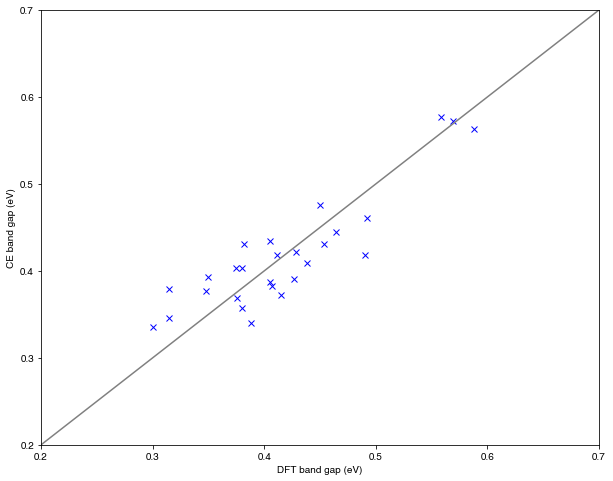

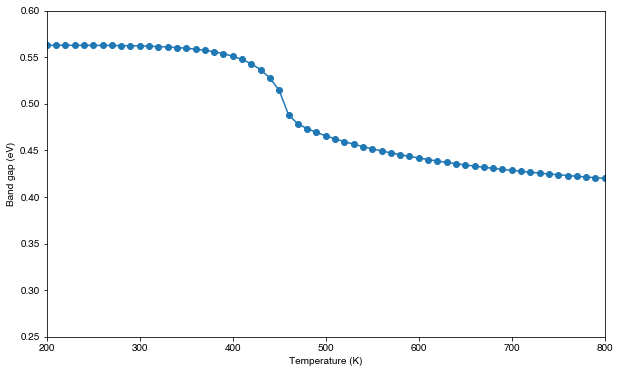

In [27]:
mat = 'czts'
w_exp = 1
gap_th = 0.3
align = True
verbose = False
clusters = [empty, point, pair_1, pair_2, triplet_1] 

model_czts = main(mat=mat, clusters=clusters, gap_th=gap_th, w_exp=w_exp, align=align, verbose=verbose)
corr_mc = ecdos(mat=mat, clusters=clusters, model=model_czts)

In [26]:
np.sqrt(-model_czts.best_score_)

0.07266947183541123

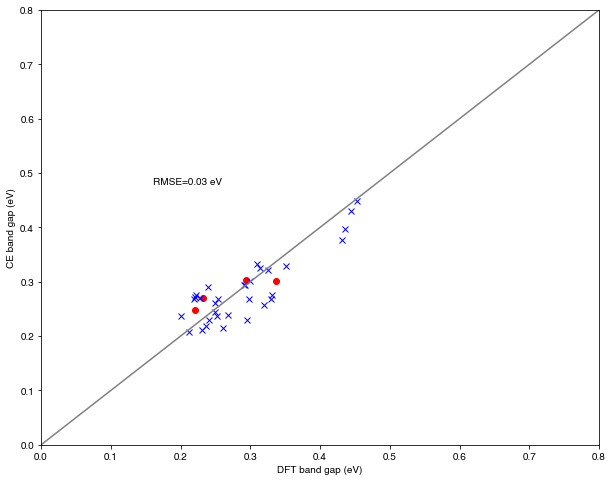

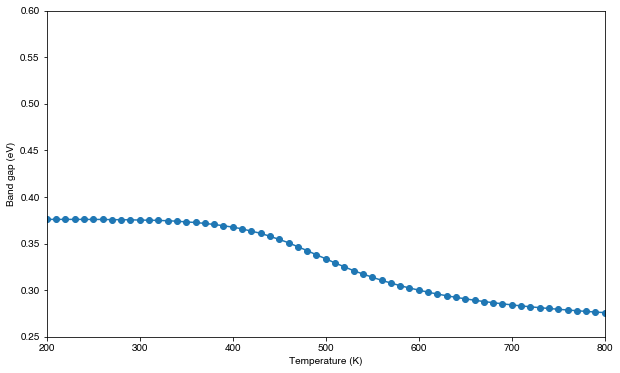

In [14]:
mat = 'ccts'
w_exp = 1
gap_th = 0.2
align = True
verbose = False
clusters = [empty, point, pair_1, pair_2, triplet_1] 

reg_ccts = main(mat=mat, clusters=clusters, gap_th=gap_th, w_exp=w_exp, align=align, verbose=verbose)
corr_mc = ecdos(mat=mat, clusters=clusters, reg=reg_ccts)